In [1]:
import pandas as pd 
import numpy as np
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from scipy.stats import mode

In [2]:
## Data_Entry_2017 contains metadata for all images and therefore it will be used for EDA except for pixel-level assessment

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
45053,00011571_008.png,No Finding,8,11571,48,F,AP,2500,2048,0.168,0.168,NaN
19371,00005136_000.png,Atelectasis|Infiltration,0,5136,51,M,PA,2500,2048,0.171,0.171,NaN
18428,00004893_082.png,Cardiomegaly,82,4893,35,M,PA,2992,2991,0.143,0.143,NaN


In [3]:
all_xray_df.shape

(112120, 12)

In [4]:
## sample_labels.csv is a small part of Data_Entry_2017.csv which will be used for pixel-level assessment

sample_df = pd.read_csv('sample_labels.csv')  
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4430,00021942_006.png,Edema,6,21942,037Y,F,AP,3056,2544,0.139,0.139
2698,00013613_027.png,Effusion,27,13613,048Y,F,AP,2500,2048,0.168,0.168
2214,00011405_000.png,No Finding,0,11405,010Y,F,PA,2458,2113,0.143,0.143


# Exploratory Data Analysis (EDA)

EDA should help informing about how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. These findings will determine how to set up the model training.

In [5]:
## Split up "Finding Labels" column so that I have one column in my dataframe per disease, with a binary flag. 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

len(all_labels) # total should be 15: 14 common thoracic pathologies + No Finding

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


15

In [6]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
35121,00009273_000.png,No Finding,0,9273,67,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52602,00013264_000.png,No Finding,0,13264,46,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49294,00012502_011.png,Consolidation|Infiltration,11,12502,30,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Number of cases (pneumonia, non-pneumonia, diseases per patient)

In [7]:
all_xray_df[all_labels].sum() # Number of cases for each disease

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [8]:
all_xray_df['Pneumonia'].sum() # Pneumonia cases

1431.0

In [9]:
len(all_xray_df) - all_xray_df['Pneumonia'].sum() # Non-pneumonia cases

110689.0

There are a total of 1431 cases of pneumonia and 110689 cases of non-pneumonia.

In [10]:
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum() # Number of cases with Pneumonia and other diseases

Atelectasis            262.0
Cardiomegaly            41.0
Consolidation          123.0
Edema                  340.0
Effusion               269.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
No Finding               0.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Pneumothorax            41.0
dtype: float64

[Text(0.5, 1.0, 'Frequency of other diseases present in the Pneumonia positive cases')]

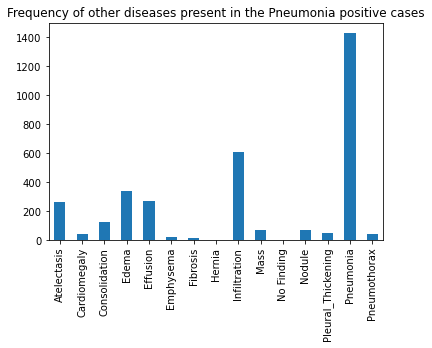

In [11]:
ax = all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum().plot(kind='bar')
ax.set(title = 'Frequency of other diseases present in the Pneumonia positive cases')

## Distribution of diseases and comorbidities

In [12]:
## Relative frequencies of each disease in the dataset

all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

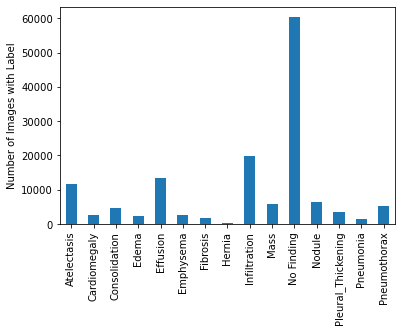

In [13]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in the dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis'.

Pneumonia appears in 1.3%. Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Now we are going to look at the diseases that are comorbid with Pneumonia:

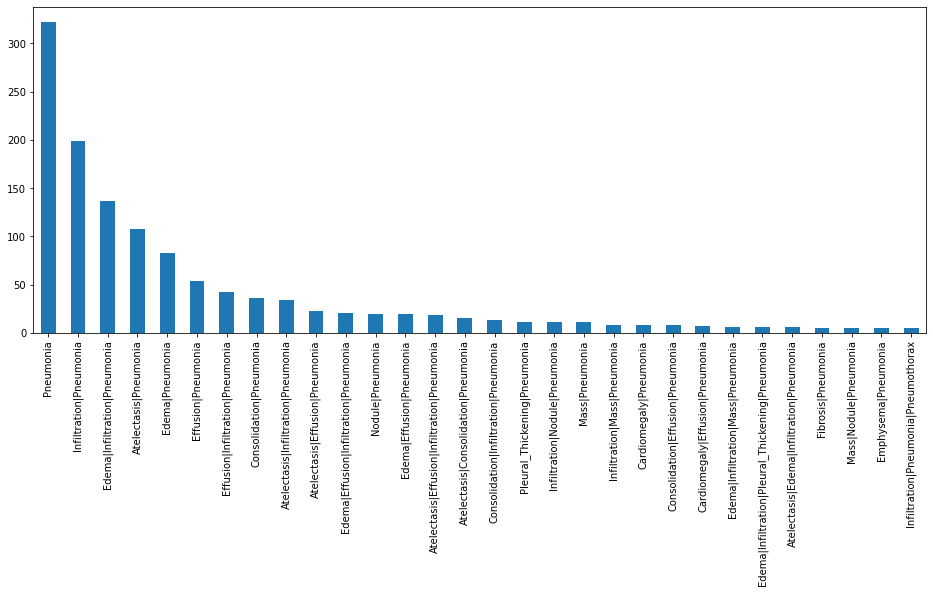

In [14]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Pneumonia occurs together with Infiltration in a high proportion. The main diseases that are comorbid with pneumonia are: Infiltration, Atelectasis, Effusion (the three most common diseases for the whole population, as shown previously), and Edema.

Now, we will look at the distribution of these diseases that are comorbid with Pneumonia:

Infiltration:

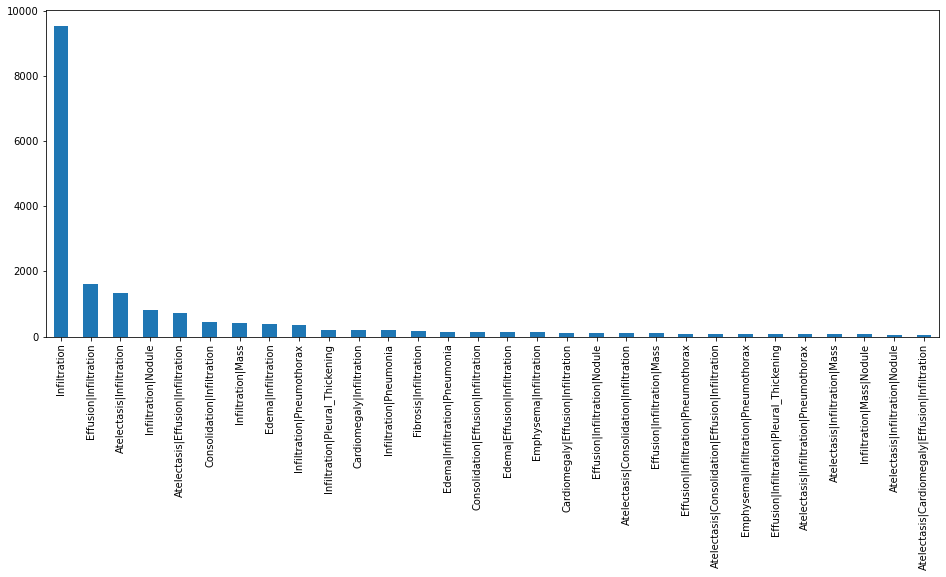

In [15]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Infiltration actually occurs alone for the most part, and that its most-common comorbidities are Effusion and Atelectasis. 

Now let's look at Edema:

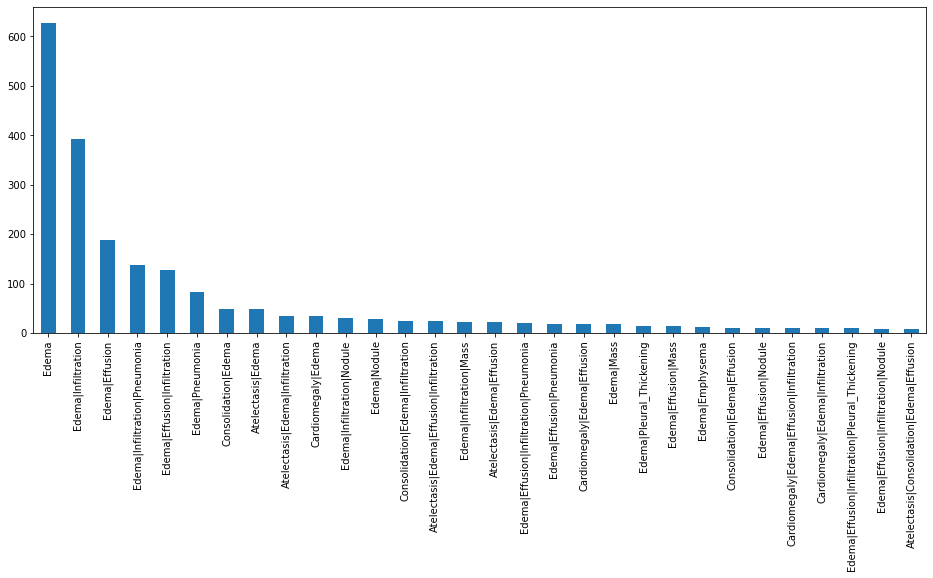

In [16]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Edema==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Edema occurs together with Infiltration in a high proportion. 

Now let's look at Atelectasis:

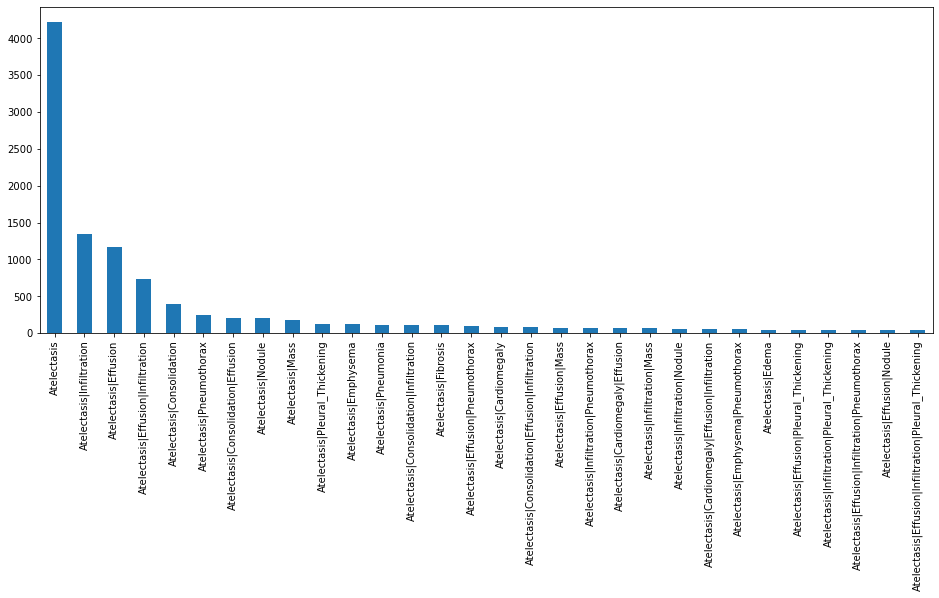

In [17]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Atelectasis==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Atelectasis occurs alone for the most part, and that its most-common comorbidities are Infiltration and Effusion. 

Finally, Effusion:

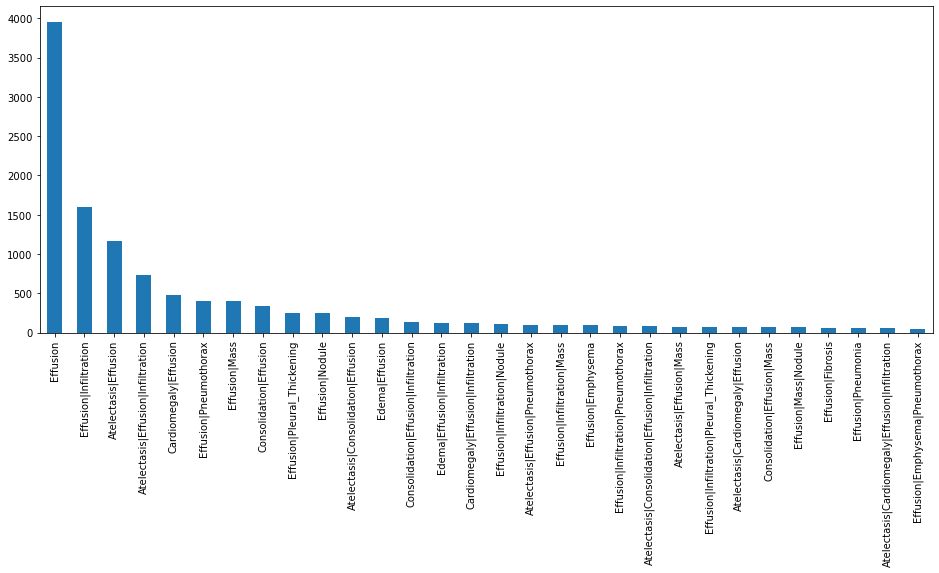

In [18]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Effusion==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Effusion also occurs alone for the most part, and that its most-common comorbidities are Infiltration and Atelectasis. 

## Patient demographic data 

### Gender

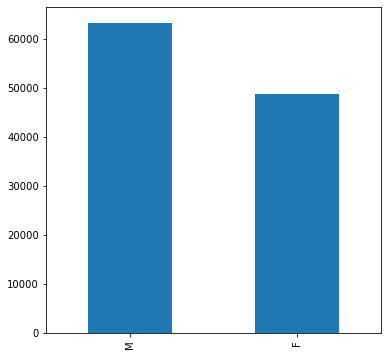

In [19]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

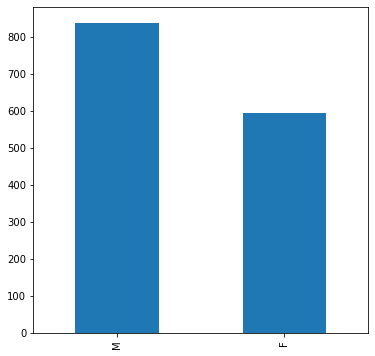

In [20]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

Gender distribution seems to be pretty equal in the whole population as well as with Pneumonia, with a slight preference towards men.

### Age 

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

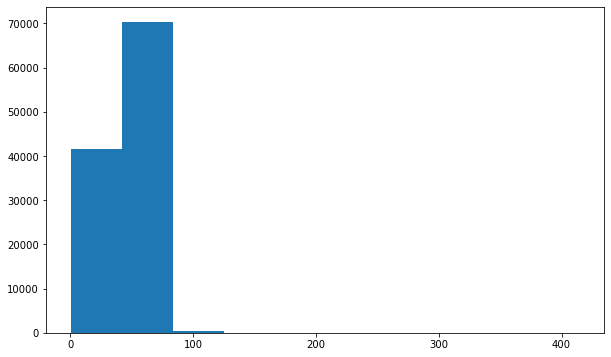

In [21]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])

There is an outlier above 400 years old:

In [22]:
max(all_xray_df['Patient Age'])

414

Data with Patient Age > 100 is going to be removed from the analysis:

In [23]:
all_xray_df.loc[all_xray_df['Patient Age'] > 100,:].shape # Number of outliers >100

(16, 27)

In [24]:
clean_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100,:] # Clean data, without outliers >100
clean_df.shape

(112104, 27)

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

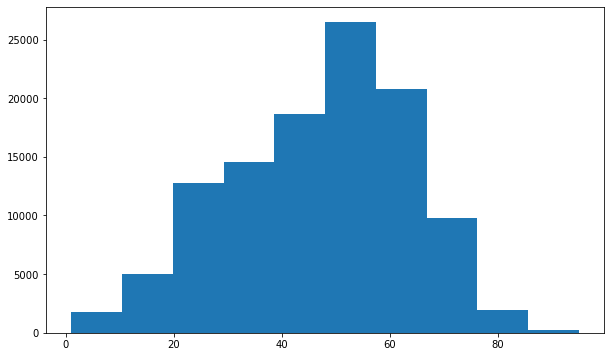

In [25]:
plt.figure(figsize=(10,6))
plt.hist(clean_df['Patient Age'])

In [26]:
max(clean_df['Patient Age'])

95

In [27]:
min(clean_df['Patient Age'])

1

Therefore, the total age distribution of the dataset is 1-95 years old.

Now let's look at the age distribution of cases with pneumonia:

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

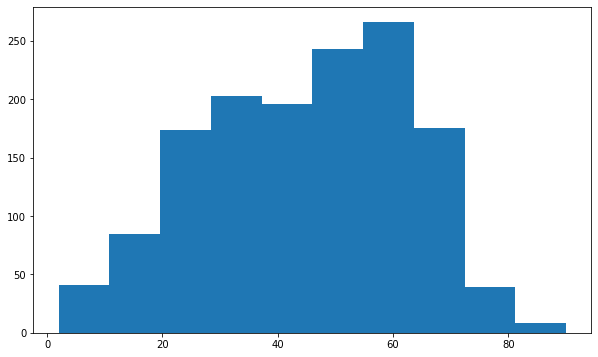

In [28]:
plt.figure(figsize=(10,6))
plt.hist(clean_df[clean_df.Pneumonia==1]['Patient Age'])

In [29]:
max(clean_df[clean_df.Pneumonia==1]['Patient Age'])

90

In [30]:
min(clean_df[clean_df.Pneumonia==1]['Patient Age'])

2

The age distribution of cases with pneumonia is 2-90 years old.

Looks like the distribution of age across the whole population is similar than it is specifically for Pneumonia. Pneumonia has its largest peak around 60. 

### Follow-up number

(array([1.025e+03, 2.040e+02, 8.900e+01, 4.900e+01, 3.700e+01, 1.100e+01,
        9.000e+00, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([  0. ,  15.5,  31. ,  46.5,  62. ,  77.5,  93. , 108.5, 124. ,
        139.5, 155. ]),
 <a list of 10 Patch objects>)

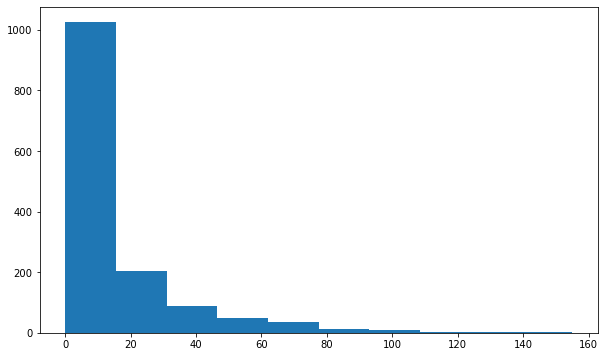

In [31]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Follow-up #'])

Most of the cases with Pneumonia have been followed-up less than 15 times.

### X-ray views taken (View Position)

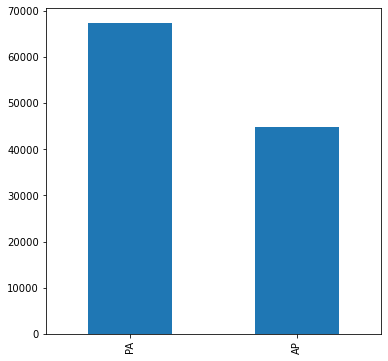

In [32]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

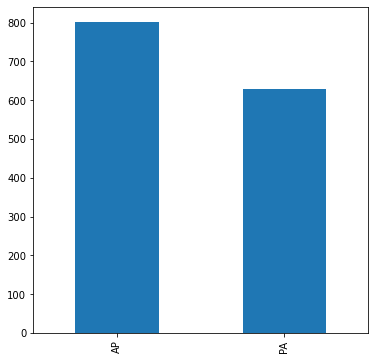

In [33]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')

While for the whole population the PA (posterioranterior) position is more common than the AP (anteroposterior), for the cases with pneumonia AP is slightly preferred over PA. 

Since 'No Finding' constitues 53.8% of the dataset, the result for the whole population must be very influenced by the position chosen when no diseases were found:

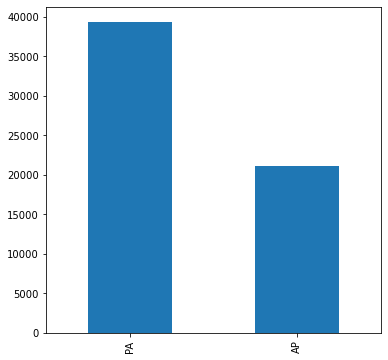

In [34]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df['No Finding'] ==1]['View Position'].value_counts().plot(kind='bar')

Exactly, for the No Finding cases, the PA position was chosen more than AP.

Now let's look at the position that was preferred for the comorbidities of Pneumonia:

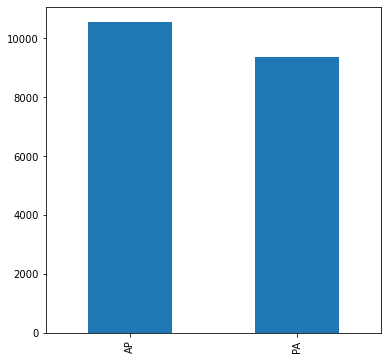

In [35]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Infiltration ==1]['View Position'].value_counts().plot(kind='bar')

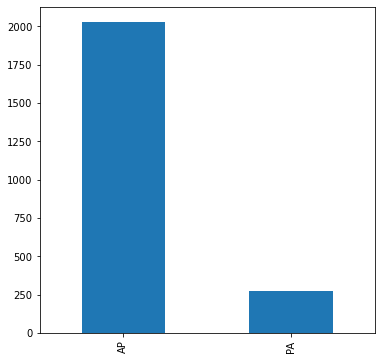

In [36]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Edema ==1]['View Position'].value_counts().plot(kind='bar')

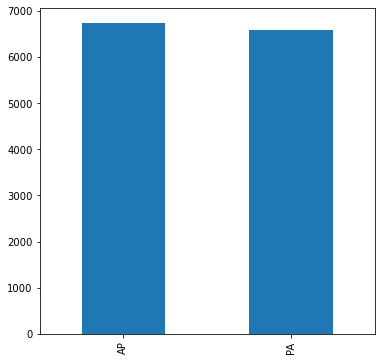

In [37]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Effusion ==1]['View Position'].value_counts().plot(kind='bar')

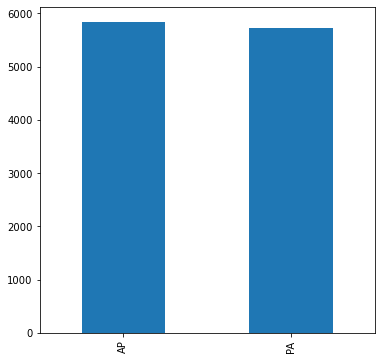

In [38]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Atelectasis ==1]['View Position'].value_counts().plot(kind='bar')

For Pneumonia and its most-common comorbidity (Infiltration) the AP position was slightly preferred over the PA. For Edema, this difference is high, being AP strongly preferred over PA. Finally, for Effusion and Atelectasis the distribution seems to be pretty equal.

## Pixel-level assessments of the imaging data

In [39]:
# We will be using sample_df for the pixel-level assessment
sample_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


In [40]:
# First, let's going to select the images that we want to take a look at. We will look at Pneumonia, No Finding (Healthy),
# Infiltration, Edema, Effusion and Atelectasis. We will analyze 3 images per disease:

labels = ['Pneumonia','No Finding','Infiltration','Edema','Effusion','Atelectasis']

for i in labels:
    print(i, 'Images:\n',sample_df[sample_df['Finding Labels']==i]['Image Index'].head(6),'\n') 
    
# I take 6 to select from there only the 3 ones without devices and wires in the images.

Pneumonia Images:
 1631    00008470_008.png
2286    00011702_043.png
2422    00012158_025.png
2522    00012667_000.png
2534    00012733_000.png
2875    00014201_008.png
Name: Image Index, dtype: object 

No Finding Images:
 2     00000017_001.png
6     00000042_002.png
7     00000057_001.png
9     00000061_019.png
12    00000080_005.png
13    00000083_000.png
Name: Image Index, dtype: object 

Infiltration Images:
 32    00000181_017.png
33    00000181_035.png
44    00000246_011.png
48    00000250_005.png
51    00000268_001.png
63    00000360_008.png
Name: Image Index, dtype: object 

Edema Images:
 225    00001249_002.png
243    00001301_020.png
282    00001504_009.png
460    00002412_000.png
486    00002533_003.png
782    00004090_002.png
Name: Image Index, dtype: object 

Effusion Images:
 8      00000061_002.png
14     00000084_000.png
15     00000096_006.png
16     00000099_003.png
25     00000127_007.png
115    00000632_011.png
Name: Image Index, dtype: object 

Atelectasis Image

In [41]:
# Now let's find the images since they are not in the same folder as the source 
!ls /data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [42]:
# The images are divided in several subfolders. We navigate a bit through all the images:
!ls /data/images*/images

/data/images_001/images:
00000001_000.png  00000318_008.png  00000643_008.png  00001022_001.png
00000001_001.png  00000318_009.png  00000644_000.png  00001022_002.png
00000001_002.png  00000318_010.png  00000644_001.png  00001023_000.png
00000002_000.png  00000319_000.png  00000645_000.png  00001023_001.png
00000003_000.png  00000320_000.png  00000645_001.png  00001023_002.png
00000003_001.png  00000321_000.png  00000646_000.png  00001023_003.png
00000003_002.png  00000321_001.png  00000646_001.png  00001024_000.png
00000003_003.png  00000321_002.png  00000646_002.png  00001025_000.png
00000003_004.png  00000321_003.png  00000646_003.png  00001026_000.png
00000003_005.png  00000321_004.png  00000646_004.png  00001027_000.png
00000003_006.png  00000321_005.png  00000646_005.png  00001027_001.png
00000003_007.png  00000322_000.png  00000646_006.png  00001028_000.png
00000004_000.png  00000322_001.png  00000646_007.png  00001028_001.png
00000005_000.png  00000322_002.png  00000647_000.png

First, we look at one of the pneumonia images:

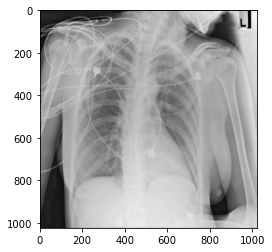

In [43]:
Pneumonia_1= plt.imread('/data/images_004/images/00008470_008.png') 
plt.imshow(Pneumonia_1, cmap='gray')

I will select another, since this one has foreign bodies (wires).

In [53]:
# Read sample image by using the image path
Pneumonia=[]
Pneumonia.append(plt.imread('/data/images_006/images/00012667_000.png')) 
Pneumonia.append(plt.imread('/data/images_006/images/00012733_000.png'))
Pneumonia.append(plt.imread('/data/images_006/images/00012158_025.png'))

Healthy=[]
Healthy.append(plt.imread('/data/images_001/images/00000017_001.png')) 
Healthy.append(plt.imread('/data/images_001/images/00000042_002.png'))
Healthy.append(plt.imread('/data/images_001/images/00000080_005.png'))

Infiltration=[]
Infiltration.append(plt.imread('/data/images_001/images/00000490_000.png')) 
Infiltration.append(plt.imread('/data/images_001/images/00000246_011.png'))
Infiltration.append(plt.imread('/data/images_001/images/00000360_008.png'))

# 00000181_017.png
#    00000181_035.png
#    00000246_011.png
#    00000250_005.png
#    00000268_001.png
#    00000360_008.png

Edema=[]
Edema.append(plt.imread('/data/images_002/images/00002412_000.png')) 
Edema.append(plt.imread('/data/images_002/images/00002533_003.png'))
Edema.append(plt.imread('/data/images_002/images/00001504_009.png'))

Effusion=[]
Effusion.append(plt.imread('/data/images_001/images/00000632_011.png')) 
Effusion.append(plt.imread('/data/images_001/images/00000099_003.png'))
Effusion.append(plt.imread('/data/images_001/images/00000096_006.png'))

Atelectasis=[]
Atelectasis.append(plt.imread('/data/images_001/images/00000030_001.png')) 
Atelectasis.append(plt.imread('/data/images_001/images/00000642_000.png'))
Atelectasis.append(plt.imread('/data/images_001/images/00000816_000.png'))

### - Pneumonia vs. Healthy

First, I will compare Pneumonia with Healthy (No Finding) cases:

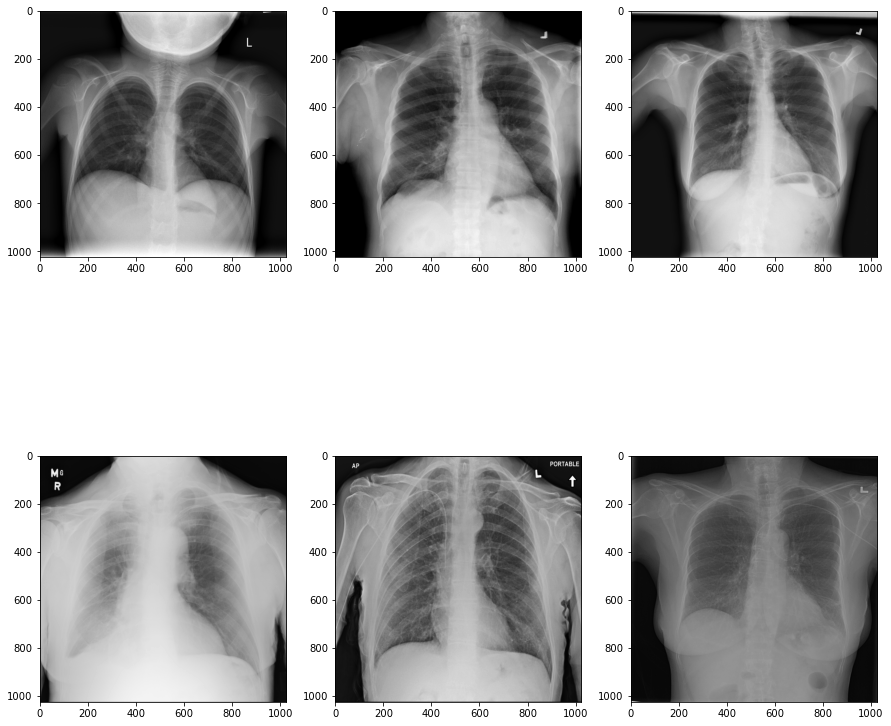

In [45]:
plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.imshow(Pneumonia[i], cmap='gray')
    plt.subplot(2,3,k), plt.imshow(Healthy[i], cmap='gray')

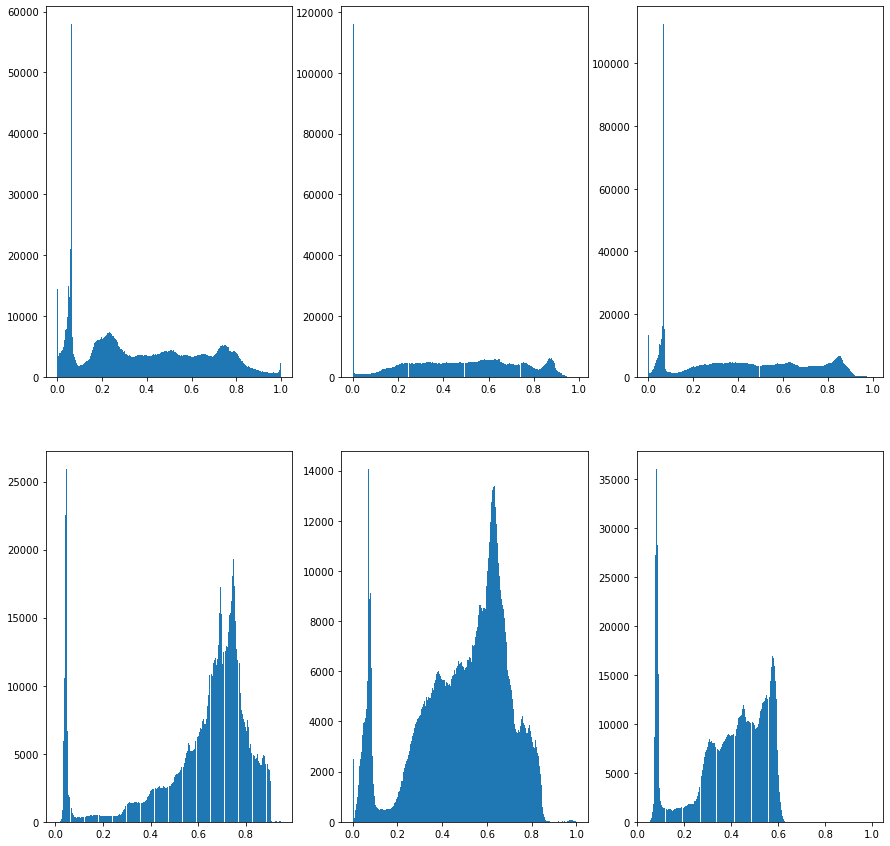

In [46]:
# Let's look at the pixel intensities:
plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.hist(Pneumonia[i].ravel(), bins=256)
    plt.subplot(2,3,k), plt.hist(Healthy[i].ravel(), bins=256)

Note the peaks at zero due to background pixels. This makes the y-axis scale to increase.

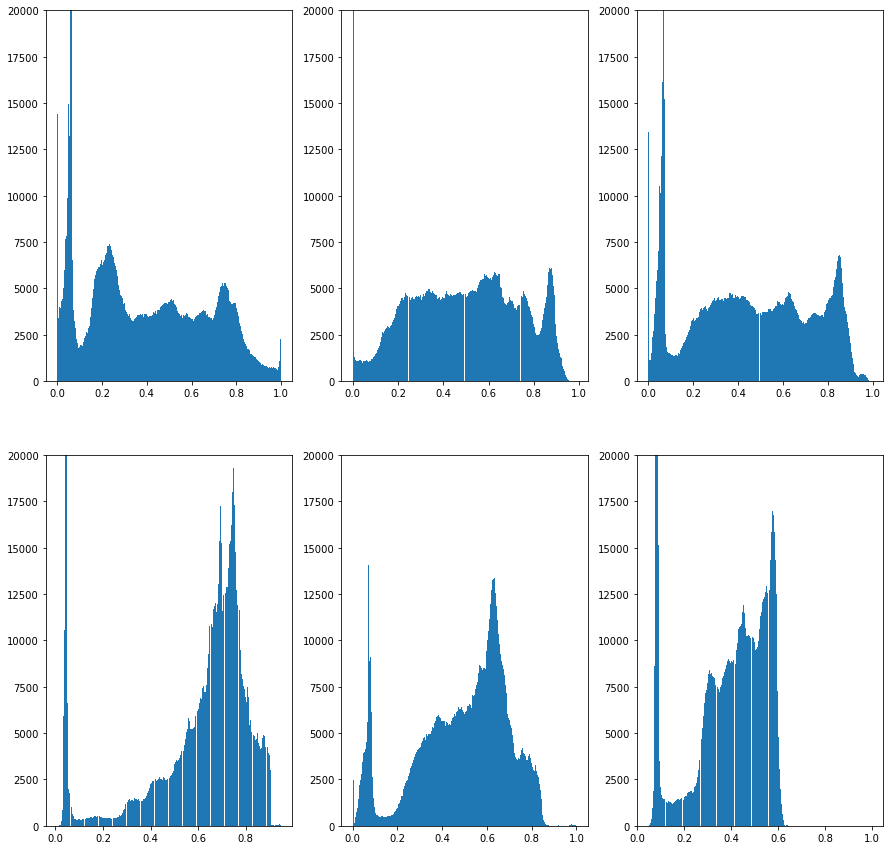

In [47]:
# I set the y axis limit to 20000 to be able to compare the intensity profiles:

plt.figure(figsize=(15,15))

for i,j,k in zip((0,1,2), (1,2,3), (4,5,6)):
    plt.subplot(2,3,j), plt.hist(Pneumonia[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(2,3,k), plt.hist(Healthy[i].ravel(), bins=256)
    plt.ylim(0, 20000)

Pneumonia and Healthy images have very different distributions. We can see that the intensity profiles of the healthy cases (2nd row) have a clear main peak, while the cases with pneumonia (1st row) have a more spread distribution and lower intensities. We will calculate the mean to compare them quantitatively:

In [48]:
# Mean:
print("Pneumonia mean intensity:", np.mean(Pneumonia))
print("Healthy mean intensity:", np.mean(Healthy))

Pneumonia mean intensity: 0.41915622
Healthy mean intensity: 0.5003894


As we saw by taking a rough look at the graphs, the mean intensity of the images with pneumonia is lower than for the images with no disease.

### - Pneumonia vs. other diseases

Now we will compare Pneumonia with all the other diseases:

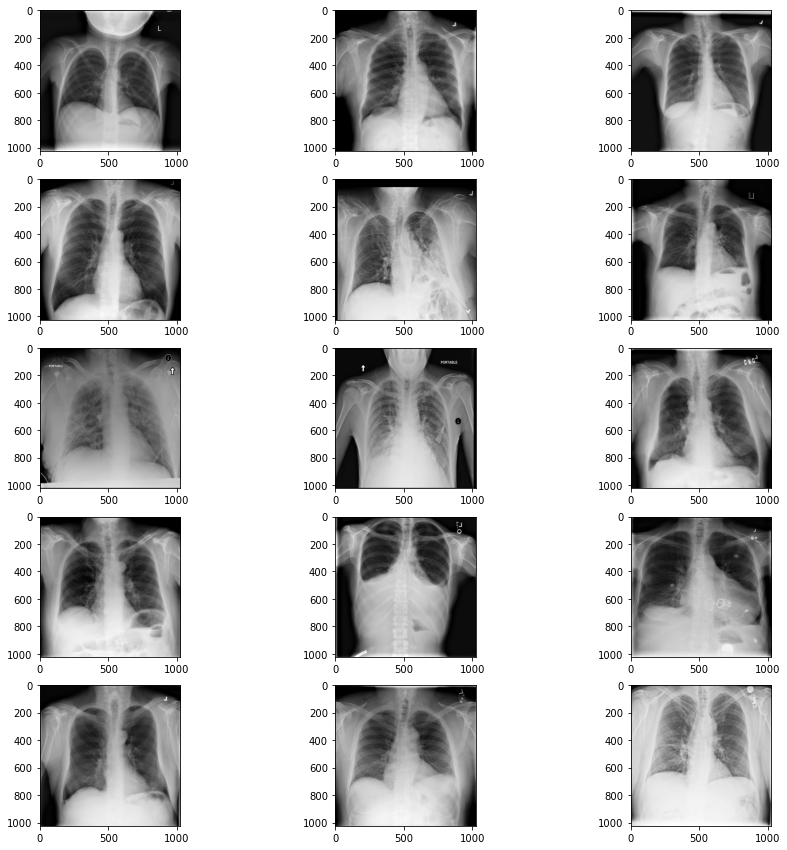

In [54]:
plt.figure(figsize=(15,15))

for i,j,k,l,m,n in zip((0,1,2), (1,2,3), (4,5,6), (7,8,9), (10,11,12), (13,14,15)):
    plt.subplot(5,3,j), plt.imshow(Pneumonia[i], cmap='gray')
    plt.subplot(5,3,k), plt.imshow(Infiltration[i], cmap='gray')
    plt.subplot(5,3,l), plt.imshow(Edema[i], cmap='gray')
    plt.subplot(5,3,m), plt.imshow(Effusion[i], cmap='gray')
    plt.subplot(5,3,n), plt.imshow(Atelectasis[i], cmap='gray')

Text(0.5, 0.98, 'Image Pixel Intensity')

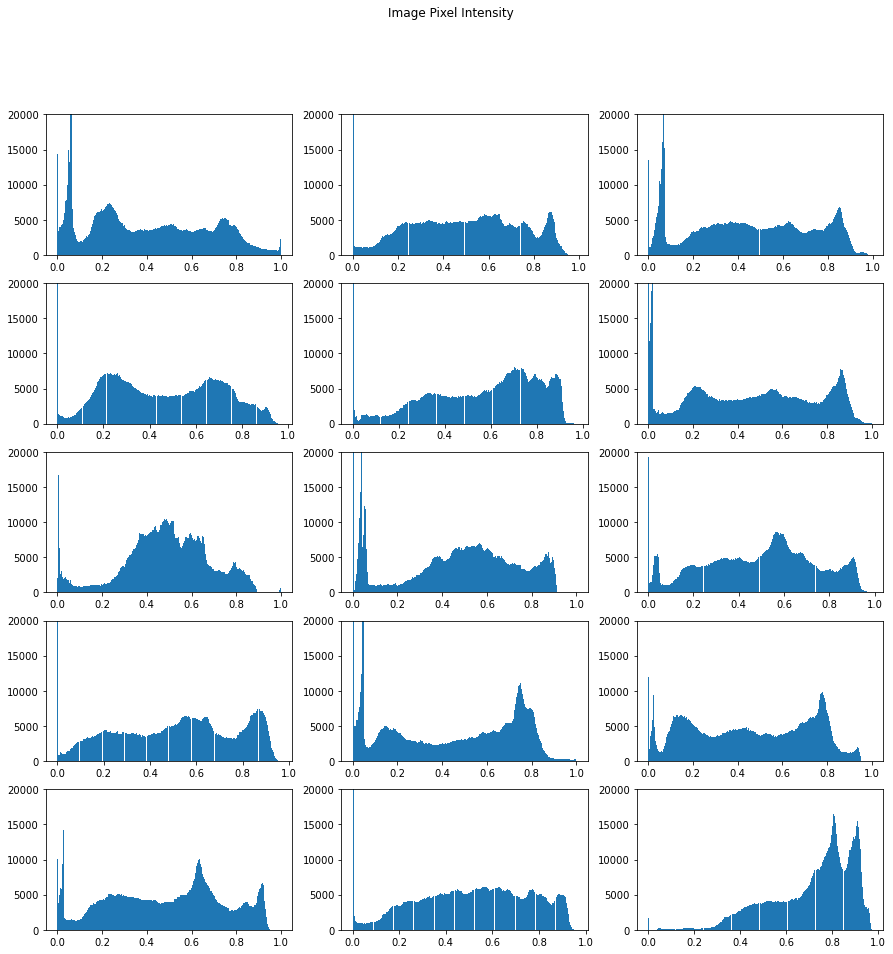

In [55]:
# Plot the histograms of the image pixel intensity values
plt.figure(figsize=(15,15))

for i,j,k,l,m,n in zip((0,1,2), (1,2,3), (4,5,6), (7,8,9), (10,11,12), (13,14,15)):
    plt.subplot(5,3,j), plt.hist(Pneumonia[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(5,3,k), plt.hist(Infiltration[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(5,3,l), plt.hist(Edema[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(5,3,m), plt.hist(Effusion[i].ravel(), bins=256)
    plt.ylim(0, 20000)
    plt.subplot(5,3,n), plt.hist(Atelectasis[i].ravel(), bins=256)
    plt.ylim(0, 20000)

plt.suptitle('Image Pixel Intensity')

We can see that Infiltration has a similar distribution as that of Pneumonia. They both have spread distributions with 2-3 peaks (0.2, 0.6, 0.9). In the case of Edema the spectra is mainly condensed around 0.5. In Effusion it looks like there is a main peak around 0.7 and for Atelectasis two main consecutive peaks.

In [51]:
# Mean:
print("Pneumonia mean intensity:", np.mean(Pneumonia))
print("Infiltration mean intensity:", np.mean(Infiltration))
print("Edema mean intensity:", np.mean(Edema))
print("Effusion mean intensity:", np.mean(Effusion))
print("Atelectasis mean intensity:", np.mean(Atelectasis))

Pneumonia mean intensity: 0.41915622
Infiltration mean intensity: 0.4370655
Edema mean intensity: 0.4774735
Effusion mean intensity: 0.46264067
Atelectasis mean intensity: 0.5729098


All the diseases have a mean pixel intensity value lower than the value for healthy lungs (0.50) except in the case of Atelectasis, which is higher. Pneumonia and Infiltration have similar intensity profiles and means, which could make difficult to distinguish between them. The mean intensity increases in this order: Pneumonia < Infiltration < Effusion < Edema < Healthy < Atelectasis. Pneumonia has the lowest mean intensity. 


## Conclusions:

The age distribution of cases with Pneumonia is 2-90 years old. The distribution of age across the whole population is similar than it is for Pneumonia. Gender distribution seems to be pretty equal in the whole population as well as with Pneumonia, with a slight preference towards men. Since the distribution of Pneumonia follows the same distribution as of the original full dataset, we do not have to change anything 

Pneumonia may occur in a combination of other diseases. Its most-common comorbidity is Infiltration, which also occurs together with Edema (its most-common comorbidity is also Infiltration). Besides, Pneumonia and Infiltration have similar pixel intensity distributions. Atelectasis and Effusion are also comorbid of Pneumonia but their pixel intensity distribution is different. These three diseases (Infiltration, Effusion and Atelectasis) are the most common (in that order) among the whole population and they are comorbid between each other. 

The pixel mean intensity of the images with Pneumonia is the lowest among its comorbidities. The pixel mean intensity increases in this order: Pneumonia (0.42) < Infiltration (0.44) < Effusion (0.46) < Edema (0.48) < Healthy (0.50) < Atelectasis (0.57). Pneumonia and Infiltration have similar intensity profiles and means, which could make difficult to distinguish between them. However, distinguishing between Pneumonia and Healthy (No Finding) would be easier. 

For Pneumonia and Infiltration the AP position was slightly preferred over the PA. For Edema, this difference is higher, being AP strongly preferred over PA. Finally, for Effusion and Atelectasis the choice of AP or PA seems to be pretty equal.

In summary, in the presence of Infiltration disease, our algorithm may work poorly because it is not able to differentiate between Pneumonia and Infiltration. This would affect the algorithm accuracy and performance so it is better to avoid Infiltration images.